# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 18 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -3 балла после 06:00 18 апреля, -6 баллов после 06:00 25 апреля, -9 баллов после 06:00 2 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw2.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
#%load_ext pycodestyle_magic

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [3]:
USER_NAME = u"Мольков".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print ("Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
))

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \frac{1}{N}\left[\sum_i \log(\sigma(y^{(i)} g(x^{(i)}))\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

Рассмотрим 
$$ L(w) = -\frac{1}{N} \left[ \sum\limits_i \ln (\sigma(y^{(i)} g(x^{(i)}))) \right] + \frac{1}{C}\sum_{j=1}^{m}|w_j|$$ 
где
$$ \sigma(z) = \frac{1}{1+e^{-z}},\quad g(x) = w_0 + <w ,x> $$ 
Тогда 
$$ \frac{\partial L}{\partial w_0} = -\frac{1}{N} \sum\limits_i (1 - \sigma(y^{(i)}g(x^{(i)}))) y^{(i)} + \frac{1}{C}sgn(w_0) $$ 
$$ \frac{\partial L}{\partial w_k} = -\frac{1}{N} \sum\limits_i (1 - \sigma(y^{(i)}g(x^{(i)}))) y^{(i)} x_k^{(i)} + \frac{1}{C}sgn(w_k) $$

## Имплементация (5 баллов)

In [3]:
#%%pycodestyle

from scipy.special import expit
from sklearn.base import BaseEstimator, ClassifierMixin


class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """

    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch

    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X_ = np.hstack((np.ones((X.shape[0], 1)), X))
        w_add = np.empty(X_.shape[1])
        ids = np.arange(y.size)
        self.epoch_loss = np.zeros(self.max_epoch+1)
        self.w = np.zeros(X_.shape[1])
        y_pred = expit(np.dot(X_, self.w))
        self.epoch_loss[0] = \
            -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()
        for epoch in range(self.max_epoch):
            for i in np.random.permutation(np.arange(X_.shape[0])):
                g = np.dot(X_[i], self.w)
                grad = (expit(g) - y[i]) * X_[i]

                coef = self.C*self.alpha/(epoch + 1)/X_.shape[0]
                w_add = self.w - self.alpha / float(epoch + 1) * grad

                self.w[w_add > 0] = np.maximum(0, w_add[w_add > 0] - coef)
                self.w[w_add < 0] = np.minimum(0, w_add[w_add < 0] + coef)

            y_pred = expit(np.dot(X_, self.w))
            self.epoch_loss[epoch + 1] = \
            -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred)).mean()

        return self

    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
        return self

    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        X_ = np.hstack((np.ones((X.shape[0], 1)), X))
        y_hat = (X_.dot(self.w) > 0).astype(int)
        return y_hat

    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X_ = np.hstack((np.ones((X.shape[0], 1)), X))
        y_hat_proba = expit(X_.dot(self.w))
        return y_hat_proba


## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

-4.664798349728522 1.052186389543871 -1.1104378113624906


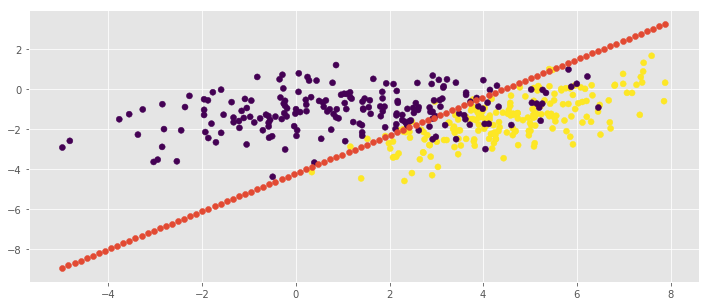

In [4]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

clf = MySGDClassifier(alpha=0.1, max_epoch=10, C=0.0002)
clf.fit(X, y)

plt.scatter(X[:,0], X[:,1], c=y)

area = np.linspace(X[:, 0].min(), X[:, 0].max(), num=100)
plt.scatter(area, - (clf.w[0] + clf.w[1] * area) / clf.w[2])

print(clf.w[0], clf.w[1], clf.w[2])


## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [5]:
from sklearn.datasets import make_classification

In [6]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

No handles with labels found to put in legend.


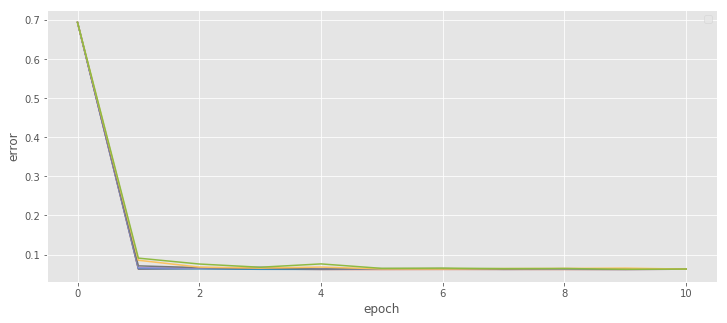

In [7]:
## Your Code Here
a = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
for alpha in a:
    clf = MySGDClassifier(max_epoch=10, alpha=alpha, C=10)
    clf.fit(X, y)
    plt.plot(np.arange(len(clf.epoch_loss)),clf.epoch_loss)
plt.xlabel("epoch")
plt.ylabel("error")
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


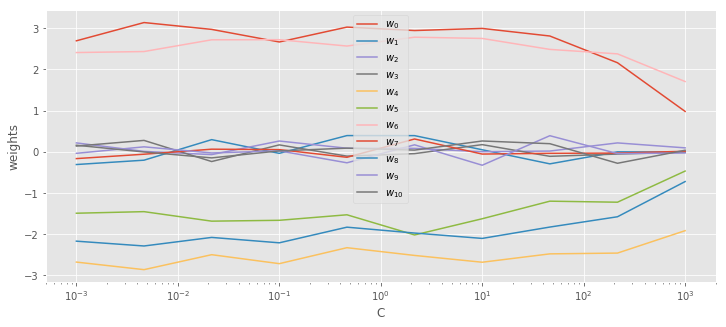

In [8]:
## Your Code Here
coeff = np.logspace(3, -3, 10)

w = np.zeros((coeff.size, X.shape[1] + 1))
for i, C in enumerate(np.logspace(3, -3, 10)):
    clf = MySGDClassifier(alpha=0.7, max_epoch=10, C=C)
    clf.fit(X, y)
    w[i, :] = clf.w
    
for i in range(X.shape[1] + 1):   
    plt.plot(np.logspace(3, -3, 10), w[:, i], label='$w_{%d}$' % i)
    plt.xscale('log')
plt.xlabel('C')
plt.ylabel('weights')
plt.legend()
plt.show()

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [9]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных
filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [10]:
df_data.shape

(500000, 45)

In [11]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [12]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [13]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [14]:
## Youd Code Here
print("количество уникальных карт героя у игрока:", np.unique(df_data.player_hero_card_id).size)
print("количество уникальных карт героя у оппонента:",np.unique(df_data.opponent_hero_card_id).size)

количество уникальных карт героя у игрока: 9
количество уникальных карт героя у оппонента: 9


In [15]:
opponent = pd.get_dummies(df_data['opponent_hero_card_id'], prefix='opponent')
player = pd.get_dummies(df_data['player_hero_card_id'], prefix='player')
df_data_onehot = df_data.join(opponent)
df_data_onehot = df_data_onehot.join(player)
df_data_onehot.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1)
df_data_onehot.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [16]:
## Youd Code Here
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
df_data_hot = pd.get_dummies(df_data, columns=['opponent_hero_card_id', 'player_hero_card_id'])

In [18]:
y = df_data_hot.iloc[:,0].values
X = df_data_hot.iloc[:,1:].values

In [20]:
clf = Pipeline([('scaler', StandardScaler()), ('classifier', MySGDClassifier(max_epoch=10, alpha=0.1, C=10))])
clf.fit(X, y)

D:\Programs\Anaconda\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in log
D:\Programs\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in multiply


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', MySGDClassifier(C=10, alpha=0.1, max_epoch=10))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [21]:
## Youd Code Here
from sklearn.metrics import roc_auc_score, roc_curve

In [22]:
df_test_list = []
for chunk in range(5,8):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_test_list.append(pd.read_csv(filepath, sep=','))
    
df_test_data = pd.concat(df_test_list)
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')

df_test_hot = pd.get_dummies(df_test_data, columns=['opponent_hero_card_id', 'player_hero_card_id'])
X_test = df_test_hot.values[:, 1:]

In [23]:
y_test = pd.read_table('deprecated_testLabels.txt', names=['decision'])

In [24]:
y_test_pred = clf.predict_proba(X_test)

In [25]:
roc_auc_score(y_test, y_test_pred)

0.7874399791029558